In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


dataset.py : load data

In [ ]:
pip install torch_geometric

In [98]:
def get_data():
  PATH1 = '/content/drive/My Drive/COMP3710/PatternFlow/recognition/46105024/data/musae_facebook_target.csv'
  PATH2 = '/content/drive/My Drive/COMP3710/PatternFlow/recognition/46105024/data/musae_facebook_edges.csv'
  PATH3 = '/content/drive/My Drive/COMP3710/PatternFlow/recognition/46105024/data/musae_facebook_features.json'
  PATH4 = '/content/drive/My Drive/COMP3710/PatternFlow/recognition/46105024/data/facebook.npz'

  import numpy as np
  facebook_npz = np.load(PATH4)

  import torch
  from torch_geometric.data import Data,Dataset
  from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit

  edges = torch.from_numpy(facebook_npz['edges'].T)
  edges = edges.long()
  features = torch.from_numpy(facebook_npz['features'])
  target = torch.from_numpy(facebook_npz['target'])

  data = Data(x=features, y=target, edge_index=edges)
  RNS = RandomNodeSplit(split='train_rest', num_val = 0.1, num_test = 0.1)
  splits = RNS(data)
  train_mask, val_mask, test_mask = splits.train_mask, splits.val_mask, splits.test_mask
  return train_mask, val_mask, test_mask, data

modules.py: create module

In [99]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN,self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


train.py: train model and draw loss graph

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [102]:
import torch
from torch_geometric.data import Data,Dataset

train_mask, val_mask, test_mask, data = get_data()
train_data = Data(x=data.x[train_mask], y=data.y[train_mask], edge_index=data.edge_index)
val_data = Data(x=data.x[val_mask], y=data.y[val_mask], edge_index=data.edge_index)
test_data = Data(x=data.x[test_mask], y=data.y[test_mask], edge_index=data.edge_index)

in_channels = train_data.num_node_features
hidden_channels = 64
out_channels = 4

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss),out

In [ ]:
def test():
    model.eval()
    out = model(data)
    val_acc = int((out[val_mask].max(1)[1] == data.y[val_mask]).sum())/int(val_mask.sum())
    test_acc = int((out[test_mask].max(1)[1] == data.y[test_mask]).sum())/int(test_mask.sum())
    return val_acc,test_acc

In [133]:
model = GCN(in_channels,hidden_channels,out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
epochs = 100
loss_ls = []
val_ls =[]
test_ls = []
old_val_acc = 0
for epoch in range(1, epochs):
  loss,out = train()
  loss_ls.append(loss)
  val_acc,test_acc = test()
  val_ls.append(val_acc)
  test_ls.append(test_acc)

  if val_acc> old_val_acc:
    torch.save(model, 'model.pt')
    old_val_acc = val_acc
  print("val_acc: " ,val_acc,", test_acc: " , test_acc)
  # accs = test()
  # print(loss,accs)

val_acc:  0.6199376947040498 , test_acc:  0.6110369381397419
val_acc:  0.7053849577214063 , test_acc:  0.6920338228749444
val_acc:  0.7507788161993769 , test_acc:  0.7338673787271918
val_acc:  0.783266577659101 , test_acc:  0.7592345349354696
val_acc:  0.8001780151312862 , test_acc:  0.7810413885180241
val_acc:  0.8095238095238095 , test_acc:  0.7992879394748553
val_acc:  0.8251001335113485 , test_acc:  0.812194036493102
val_acc:  0.8348909657320872 , test_acc:  0.8210947930574098
val_acc:  0.8460169114374722 , test_acc:  0.8304405874499332
val_acc:  0.8526924788607032 , test_acc:  0.8371161548731643
val_acc:  0.8571428571428571 , test_acc:  0.8446817979528259
val_acc:  0.8584779706275033 , test_acc:  0.8491321762349799
val_acc:  0.8624833110814419 , test_acc:  0.8549176680017802
val_acc:  0.8678237650200267 , test_acc:  0.8580329327992879
val_acc:  0.8740542946150422 , test_acc:  0.8602581219403649
val_acc:  0.8789497107254116 , test_acc:  0.8611481975967957
val_acc:  0.88206497552291

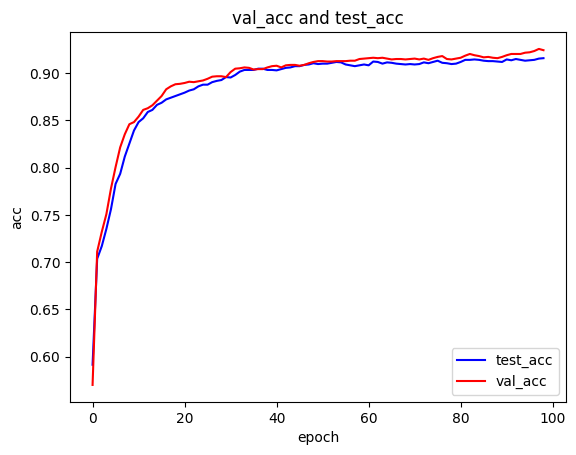

In [131]:
plt.plot(range(len(test_ls)), test_ls,  color='b', label="test_acc")
plt.plot(range(len(val_ls)), val_ls,  color='r', label="val_acc")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('val_acc and test_acc')
plt.legend()

Text(0.5, 1.0, 'Training loss')

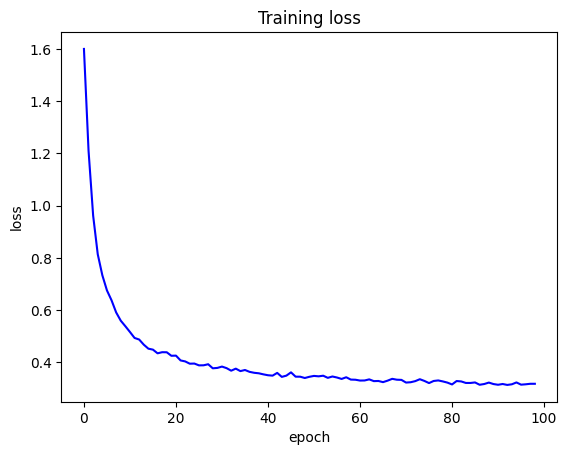

In [116]:
plt.plot(range(len(loss_ls)), loss_ls,  color='b', label="Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss')

predict.py : visualization, result

In [134]:
gcn_m = torch.load('model.pt')
out = gcn_m(data)
test_acc = int((out[test_mask].max(1)[1] == data.y[test_mask]).sum())/int(test_mask.sum())

In [135]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
embeddings = model(data).detach().numpy()
embeddings_2d = tsne.fit_transform(embeddings)

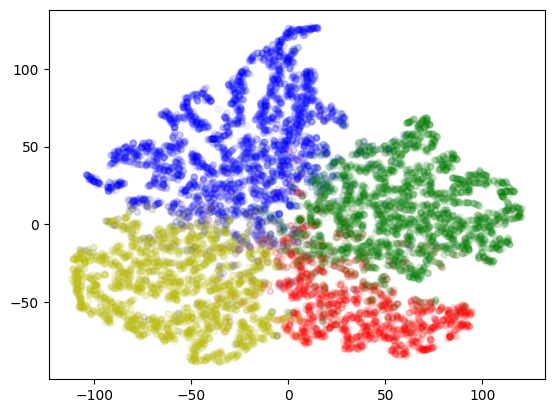

In [136]:
import matplotlib.pyplot as plt
colors = ['r', 'g', 'b','y'] # Use different colors for different classes
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1],s=20,alpha = 0.05,c=[colors[label] for label in data.y])
plt.show()